In [1]:
#Importer Keras avec le backend tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Définir tous les paramètres utiles pour les étapes qui viennet
# Set dataset folder path
BASE_DATASET_FOLDER = "/home/chakour/Desktop/UBUNTU/dataset_training/STARE & DRIVE/"
TRAIN_FOLDER = "/home/chakour/Desktop/UBUNTU/dataset_training/STARE & DRIVE/training"
VALIDATION_FOLDER = "/home/chakour/Desktop/UBUNTU/dataset_training/STARE & DRIVE/validation"
TEST_FOLDER = "/home/chakour/Desktop/UBUNTU/dataset_training/STARE & DRIVE/test"

# ResNet50 image size
IMAGE_SIZE = (255, 255)    
INPUT_SHAPE = (255, 255, 3)

# Keras settings
TRAIN_BATCH_SIZE = 40
VAL_BATCH_SIZE = 10
EPOCHS = 10    # a chaque epoch le model train toute la data
LEARNING_RATE = 0.0001   # pour ajuster les poid wi en ajustant avec un pas trés petit pour une meilleur performance
MODEL_PATH = os.path.join("diabetic_retinopathy_detection_STARE-DRIVE_disc_optic.h5")


In [3]:
# une fonction pour le calcule des pourcentage
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)  

# une fonction pour l'affichage de répartition des images en pourcentage 

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.ppm")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

In [4]:
# Generate batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Generates a tf.data.Dataset from image files in a directory.
train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 397 images belonging to 5 classes.


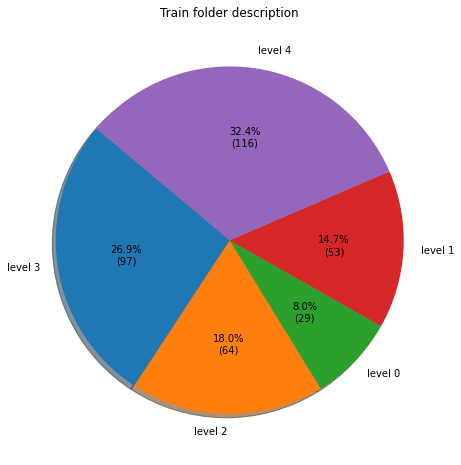

In [5]:
# voir la répartition des images de training en terme de pourcentage
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER), "Train folder description")

In [6]:
# voir la répartition des images de validation en terme de pourcentage

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 102 images belonging to 5 classes.


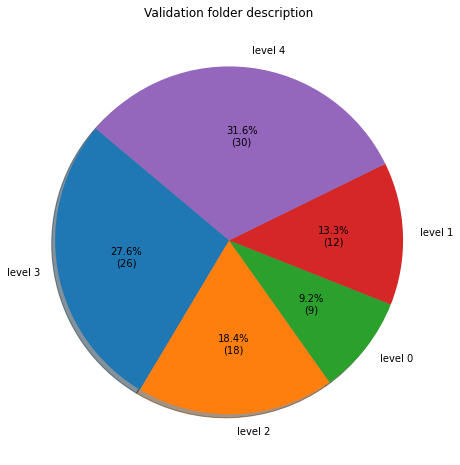

In [7]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER), "Validation folder description")

In [25]:
# voir la répartition des images de test en terme de pourcentage

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 80 images belonging to 5 classes.


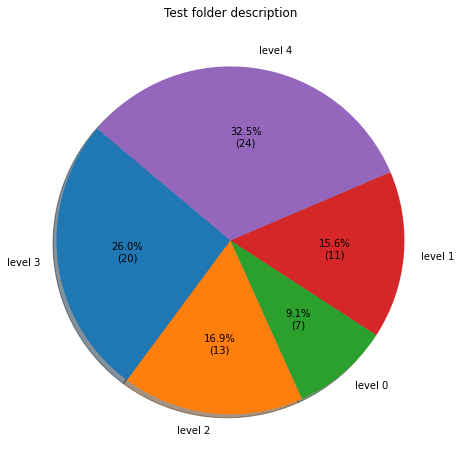

In [26]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER), "Test folder description")

In [10]:
# afficher les classes avec ces indices 
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'level 0', 1: 'level 1', 2: 'level 2', 3: 'level 3', 4: 'level 4'}


In [11]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [12]:
# Freeze the layers except the last 4 layers 
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [13]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [14]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6

In [15]:
# Compile the model with the optimizer Adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [16]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/10
9/9 [==============================] - 184s 21s/step - loss: 1.7936 - acc: 0.2363 - val_loss: 1.5977 - val_acc: 0.2708
Epoch 2/10
9/9 [==============================] - 184s 21s/step - loss: 1.5506 - acc: 0.2940 - val_loss: 1.5332 - val_acc: 0.2396
Epoch 3/10
9/9 [==============================] - 185s 21s/step - loss: 1.6163 - acc: 0.2616 - val_loss: 1.5496 - val_acc: 0.2917
Epoch 4/10
9/9 [==============================] - 185s 21s/step - loss: 1.5486 - acc: 0.3507 - val_loss: 1.5344 - val_acc: 0.2708
Epoch 5/10
9/9 [==============================] - 185s 21s/step - loss: 1.5441 - acc: 0.2928 - val_loss: 1.5141 - val_acc: 0.2500
Epoch 6/10
9/9 [==============================] - 184s 21s/step - loss: 1.5267 - acc: 0.2922 - val_loss: 1.5251 - val_acc: 0.2604
Epoch 7/10
9/9 [==============================] - 184s 21s/step - loss: 1.5115 - acc: 0.3172 - val_loss: 1.5482 - val_acc: 0.2604
Epoch 8/10
9/9 [==============================] - 185s 21s/step - loss: 1.5564 - acc: 0.27

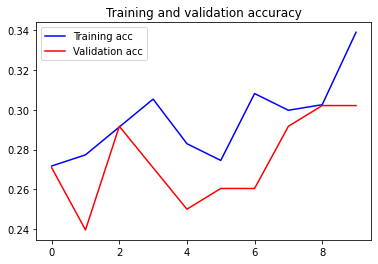

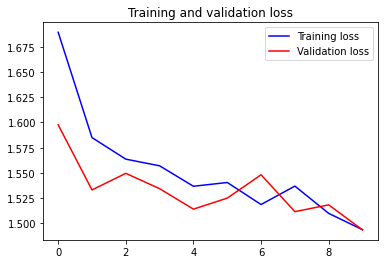

In [17]:
# Plot training and validation accuracy and loss
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
# affichage de Training and validation accuracy 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
# affichage de Training and validation accuracy 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [18]:
%%time
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

CPU times: user 1min 44s, sys: 2.42 s, total: 1min 47s
Wall time: 27.7 s


In [19]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))


Accuracy: 0.300000
Loss: 1.480304


In [27]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

8/8 [==============================] - 25s 3s/step
CPU times: user 1min 32s, sys: 2.51 s, total: 1min 34s
Wall time: 24.9 s


In [28]:
y_pred = np.argmax(Y_pred, axis=1)

In [29]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [30]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

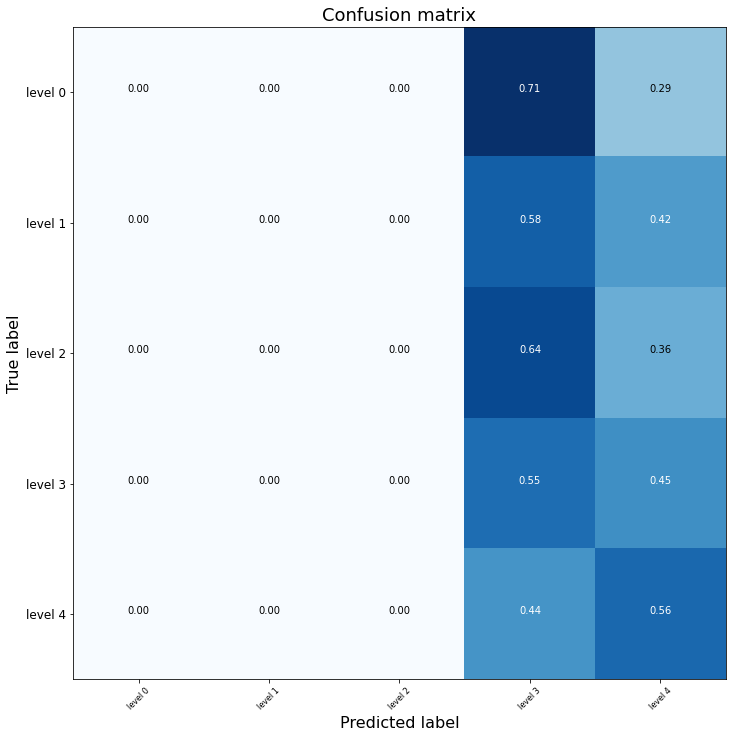

In [31]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [32]:
def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

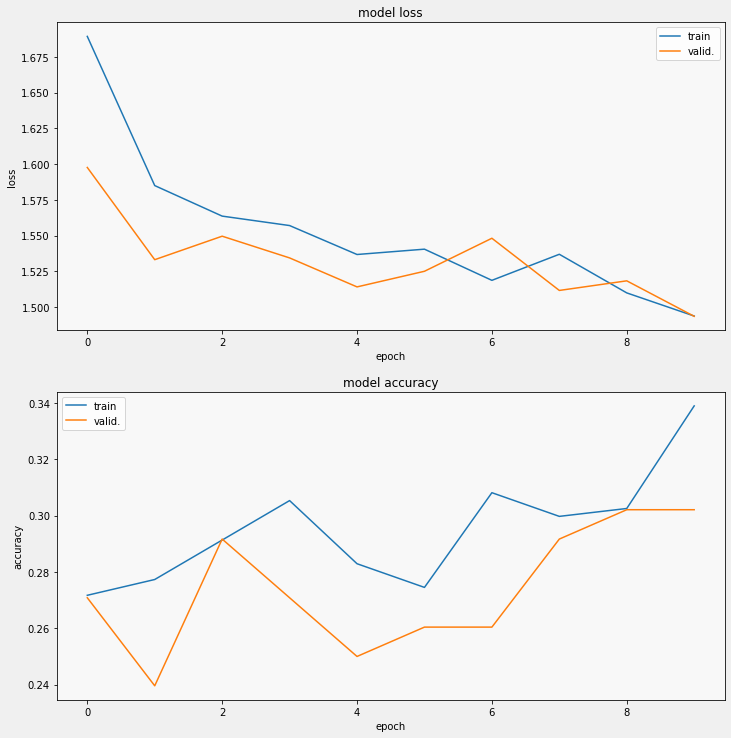

In [33]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 212)

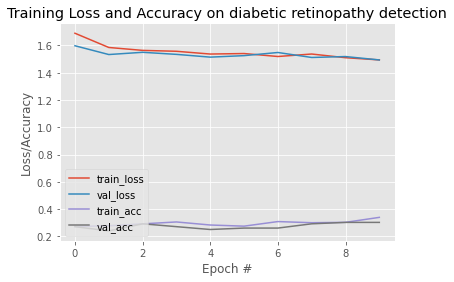

In [34]:
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output

sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")